In [79]:
import csv
import pickle
import re
from datetime import datetime
import numpy as np
# randn = np.random.randn
from pandas import *
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import linregress
from pylab import *
from urllib import urlopen
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from __future__ import division
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn import tree
from sklearn.externals.six import StringIO
import os
from sklearn.externals.six import StringIO  
import pydot
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold


## Features Pre-Processing

Data: Bank Full Additional (20 features - 41188 samples)

Getting first results with all available features

Gradually pruning out features with least influence on the outcome (different instances, same outcome)

Checking accuracy and Roc-Auc at each step

Stopping the pruning process when performances begin to clearly decrease

About same performances with a model with half features => better (generalization)

## Variables Pre-processing

### Categorical:

01 - contact: cellular = 1

02 - job: student, retired = 1

03 - marital: single = 1

04 - poutcome (failure, nonexistent, success): success = 1

### Continuous:

05 - age: parabola centered around age 47

06 - campaign (contacts in present campaign): 1 / value

07 - emp.var.rate: 1 - normalized value

08 - euribor3m: 1- normalized value

09 - pdays (days from last campaign contact, or 999): !=999 = 1

10 - previous (number of contacts in previous campaign): !=0 = 1

In [2]:
bank_full = read_csv('bank-additional-full.csv', delimiter=';', header=0)
bank_full.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [3]:
bank = bank_full[['age','job','marital','contact','campaign','pdays','previous','poutcome','emp.var.rate','euribor3m','y']]
bank.head(3)

,age,job,marital,contact,campaign,pdays,previous,poutcome,emp.var.rate,euribor3m,y
0,56,housemaid,married,telephone,1,999,0,nonexistent,1.1,4.857,no
1,57,services,married,telephone,1,999,0,nonexistent,1.1,4.857,no
2,37,services,married,telephone,1,999,0,nonexistent,1.1,4.857,no


In [4]:
pd.options.mode.chained_assignment = None

In [5]:
bank['y'] = bank['y'].map({'yes': 1, 'no': 0})

In [6]:
bank['age'] =((bank['age']-47)/30) ** 2
bank['age'][bank['age'] > 1] = 1

In [7]:
bank['job'][bank['job'] == 'student'] = 1
bank['job'][bank['job'] == 'retired'] = 1
bank['job'][bank['job'] != 1] = 0

In [8]:
bank['marital'][bank['marital'] == 'single'] = 1
bank['marital'][bank['marital'] != 1] = 0

In [9]:
bank['contact'][bank['contact'] == 'cellular'] = 1
bank['contact'][bank['contact'] != 1] = 0

In [10]:
bank['campaign'] = 1 / bank['campaign']

In [11]:
bank['pdays'][bank['pdays'] != 999] = 1
bank['pdays'][bank['pdays'] == 999] = 0

In [12]:
bank['previous'][bank['previous'] != 0] = 1
bank['previous'][bank['previous'] != 1] = 0

In [13]:
bank['poutcome'][bank['poutcome'] == 'failure'] = 0
bank['poutcome'][bank['poutcome'] == 'nonexistent'] = 0
bank['poutcome'][bank['poutcome'] == 'success'] = 1

In [14]:
bank['emp.var.rate'] = abs((bank['emp.var.rate'] - 1.4) / 4.8)

In [15]:
bank['euribor3m'] = 1 - (bank['euribor3m'] / 5.5)

In [16]:
bank.head(5)

,age,job,marital,contact,campaign,pdays,previous,poutcome,emp.var.rate,euribor3m,y
0,0.090000,0,0,0,1,0,0,0,0.0625,0.116909,0
1,0.111111,0,0,0,1,0,0,0,0.0625,0.116909,0
2,0.111111,0,0,0,1,0,0,0,0.0625,0.116909,0
3,0.054444,0,0,0,1,0,0,0,0.0625,0.116909,0
4,0.090000,0,0,0,1,0,0,0,0.0625,0.116909,0


In [17]:
byes = bank[bank['y'] == 1]
bno = bank[bank['y'] == 0]

In [18]:
print len(byes), len(bno), (len(byes)/len(bank)), (len(bno)/len(bank))

4640 36548 0.112654171118 0.887345828882


In [19]:
X = bank.drop('y', 1)
y = bank['y']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.15, random_state=0)

In [20]:
print X.shape, X_train.shape, X_test.shape

(41188, 10) (35009, 10) (6179, 10)


In [21]:
acc_scores = {}
for n in range(20):
    clf = KNeighborsClassifier(n_neighbors=(n+1)).fit(X_train, y_train)
    y_pred_knn = clf.predict(X_test)
    acc_scores.setdefault((n+1), [])
    acc_scores[(n+1)].append(accuracy_score(y_test, y_pred_knn))

In [22]:
print acc_scores

{1: [0.84932837028645414], 2: [0.89399579219938496], 3: [0.88897879915843991], 4: [0.89626153099206995], 5: [0.89512866159572746], 6: [0.89755623887360414], 7: [0.89626153099206995], 8: [0.90046933160705611], 9: [0.89642336947726164], 10: [0.89804175432917943], 11: [0.89771807735879594], 12: [0.89787991584398774], 13: [0.89771807735879594], 14: [0.89771807735879594], 15: [0.89820359281437123], 16: [0.90030749312186442], 17: [0.89901278524033013], 18: [0.89982197766628902], 19: [0.89836543129956303], 20: [0.90063117009224791]}


In [23]:
nmax = max(acc_scores, key=acc_scores.get)
nmax

20

In [24]:
clf = KNeighborsClassifier(n_neighbors = (nmax))
knn_model = clf.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)

In [25]:
X_test = X_test.astype(float)
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)

In [26]:
clf = GaussianNB()
gnb_model = clf.fit(X_train, y_train)
y_pred_gnb = gnb_model.predict(X_test)
y_proba_gnb = gnb_model.predict_proba(X_test)

In [27]:
clf = SVC(probability=True)
svc_model = clf.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
y_proba_svc = svc_model.predict_proba(X_test)

In [28]:
clf = DecisionTreeClassifier()
dtc_model = clf.fit(X_train, y_train)
y_pred_dtc = dtc_model.predict(X_test)
y_proba_dtc = dtc_model.predict_proba(X_test)

In [29]:
clf = RandomForestClassifier()
rfc_model = clf.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)
y_proba_rfc = rfc_model.predict_proba(X_test)

In [30]:
#clf = tree.DecisionTreeClassifier()
#tdt_model = clf.fit(X_train, y_train)
#y_pred_tdt = tdt_model.predict(X_test)
#y_proba_tdt = tdt_model.predict_proba(X_test)
#accuracy_score(y_test, y_pred_tdt)

In [31]:
#with open("bank.dot", 'w') as f:
#    f = tree.export_graphviz(clf, out_file=f)
#os.unlink('bank.dot')
#dot_data = StringIO() 
#tree.export_graphviz(clf, out_file=dot_data) 
#graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
#graph.write_pdf("bank.pdf")

# GLM ?

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_knn[:,1])
roc_auc_knn = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_knn, pos_label = None, average = None)

(array([ 0.91246416,  0.62      ]),
 array([ 0.98274296,  0.22997033]),
 array([ 0.94630051,  0.33549784]),
 array([5505,  674]))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


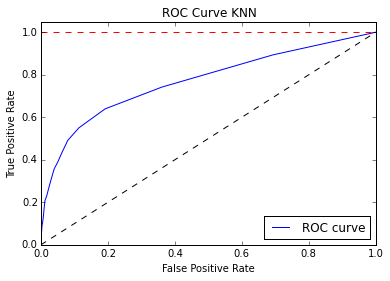

In [33]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN')
plt.legend(loc="lower right")
plt.show()

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_log[:,1])
roc_auc_log = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_log, pos_label = None, average = None)

(array([ 0.91003518,  0.65238095]),
 array([ 0.98673933,  0.20326409]),
 array([ 0.94683633,  0.30995475]),
 array([5505,  674]))

Populating the interactive namespace from numpy and matplotlib


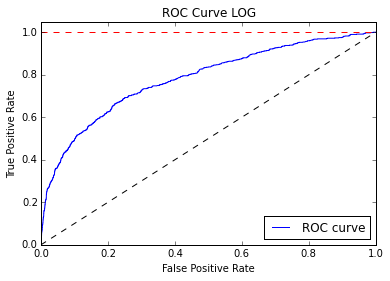

In [35]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_log)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LOG')
plt.legend(loc="lower right")
plt.show()

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_gnb[:,1])
roc_auc_gnb = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_gnb, pos_label = None, average = None)

(array([ 0.92212389,  0.44234405]),
 array([ 0.94641235,  0.34718101]),
 array([ 0.93411026,  0.38902743]),
 array([5505,  674]))

Populating the interactive namespace from numpy and matplotlib


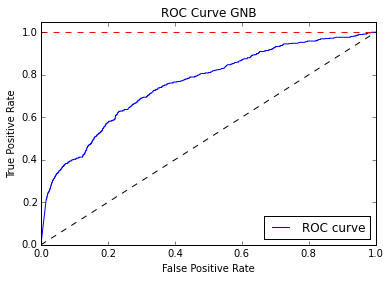

In [37]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_gnb)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve GNB')
plt.legend(loc="lower right")
plt.show()

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_svc[:,1])
roc_auc_svc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_svc, pos_label = None, average = None)

(array([ 0.9109094 ,  0.62608696]),
 array([ 0.98437784,  0.21364985]),
 array([ 0.94621966,  0.31858407]),
 array([5505,  674]))

Populating the interactive namespace from numpy and matplotlib


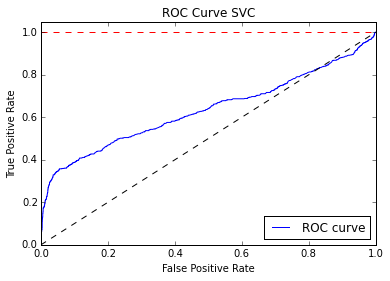

In [39]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_svc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVC')
plt.legend(loc="lower right")
plt.show()

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_dtc[:,1])
roc_auc_dtc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_dtc, pos_label = None, average = None)

(array([ 0.91911504,  0.41020794]),
 array([ 0.94332425,  0.32195846]),
 array([ 0.9310623 ,  0.36076475]),
 array([5505,  674]))

Populating the interactive namespace from numpy and matplotlib


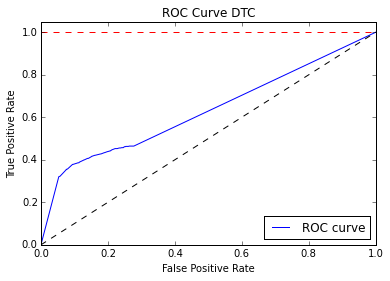

In [41]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_dtc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DTC')
plt.legend(loc="lower right")
plt.show()

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_rfc[:,1])
roc_auc_rfc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_rfc, pos_label = None, average = None)

(array([ 0.91616249,  0.47969543]),
 array([ 0.96276113,  0.28041543]),
 array([ 0.93888397,  0.35393258]),
 array([5505,  674]))

Populating the interactive namespace from numpy and matplotlib


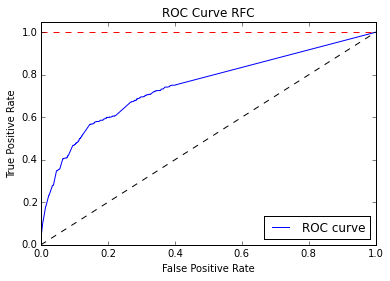

In [43]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_rfc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RFC')
plt.legend(loc="lower right")
plt.show()

In [44]:
X = X.astype(float)
cv = StratifiedKFold(y, n_folds=4)

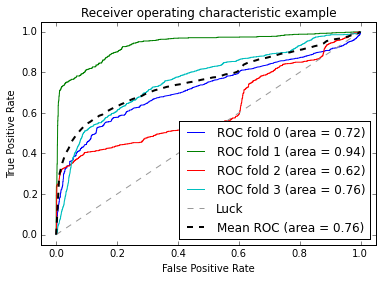

In [45]:
classifier = LogisticRegression()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # Compute ROC curve and area the curve
    probas_ = classifier.fit(X.iloc[train,:], y[train]).predict_proba(X.iloc[test,:])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:,1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [46]:
accuracy_score(y_test, y_pred_knn)

0.90063117009224791

In [47]:
accuracy_score(y_test, y_pred_log)

0.901278524033015

In [48]:
accuracy_score(y_test, y_pred_gnb)

0.88104871338404267

In [49]:
accuracy_score(y_test, y_pred_svc)

0.90030749312186442

In [50]:
accuracy_score(y_test, y_pred_dtc)

0.87554620488752222

In [51]:
accuracy_score(y_test, y_pred_rfc)

0.88833144521767271

In [52]:
roc_auc_knn

0.76930872123265337

In [53]:
roc_auc_log

0.78126399793012558

In [54]:
roc_auc_gnb

0.75742715686036699

In [55]:
roc_auc_svc

0.63346364378754672

In [56]:
roc_auc_dtc

0.63049453289025092

In [57]:
roc_auc_rfc

0.74944560785043002

In [58]:
px2 = X_test.reshape((-1,10))
X_err = pd.DataFrame({'age':px2[:,0],'job':px2[:,1],'marital':px2[:,2],'contact':px2[:,3],'campaign':px2[:,4],'pdays':px2[:,5],'previous':px2[:,6],'poutcome':px2[:,7],'emp.var.rate':px2[:,8],'euribor3m':px2[:,9]})

In [59]:
y_err = y_pred_log - y_test

In [60]:
indneg = []
indpos = []
for r in range(len(y_err)):
    if y_err[r] == 1:
        indpos.append(r)
    if y_err[r] == -1:
        indneg.append(r)

print len(indneg), len(indpos)

537 73


In [61]:
X_ones_missed = X_err.iloc[indneg,:]

In [62]:
X_zeroes_missed = X_err.iloc[indpos,:]

In [63]:
mean(byes)

age             0.244659
job             0.152802
marital         0.349138
contact         0.830388
campaign        0.691456
pdays           0.208405
previous        0.323060
poutcome        0.192672
emp.var.rate    0.548635
euribor3m       0.613975
y               1.000000
dtype: float64

In [64]:
mean(bno)

age             0.163570
job             0.051603
marital         0.272190
contact         0.609910
campaign        0.626513
pdays           0.014994
previous        0.112893
poutcome        0.013106
emp.var.rate    0.239818
euribor3m       0.307002
y               0.000000
dtype: float64

In [65]:
sum(mean(byes))

5.1551919387929868

In [66]:
sum(mean(bno))

2.4115983427854122

In [67]:
mean(X_ones_missed)

age             0.229369
campaign        0.691406
contact         0.815642
emp.var.rate    0.506712
euribor3m       0.558903
job             0.132216
marital         0.342644
pdays           0.013035
poutcome        0.001862
previous        0.148976
dtype: float64

In [68]:
mean(X_zeroes_missed)

age             0.277412
campaign        0.683121
contact         0.931507
emp.var.rate    0.746861
euribor3m       0.826279
job             0.246575
marital         0.479452
pdays           1.000000
poutcome        0.931507
previous        1.000000
dtype: float64

In [69]:
sum(mean(X_ones_missed))

3.4407656511706786

In [70]:
sum(mean(X_zeroes_missed))

7.1227145921050026

## Model Outcomes

The performance is quite the same with any model; it should be a hint of reliability (hopefully!)

Accuracy is around 90% and ROC AUC is around 0.78 (confirmed by stratified folding, and many different testing sizes)

Best classifiers are Logistic Regression and K-Neighbours

Turns out that at least half of the features are somehow useless

An analysis upon the wrongly predicted samples shows that they are quite anomalous with respect to all other samples, and then it's very difficult to correctly classify them by using the available features

Chances to sell the product are higher when the customer is: 

Already contacted in previous campaign and possibly bought a bank product;

youngest and oldest; 

student or retired;

singles;

contact through cellular (less time to think?);

when unemployment is rising;

when interest rates are relatively low;

If one contact is not enough, probably it's better giving up.

## Conclusions

The prediction models can help in finding the right customer for our product, but the available data are not so perfect or complete.

For the future campaigns, it'd be better adding more features, that should be focused on better classifying the customer wealth profile and risk aversion and for better understanding her/his ability in standing a temporary lock on part of her/his savings.

Say, for instance: which other products she/he bought, for which amount, and when.